# 3.0 Lightning Model

## Reading the dataset

In [1]:
import pandas as pd

ratings = pd.read_csv("../data/processed/ratings_embeddings.csv")

ratings.head()

,user_id,item_id,rating,timestamp,genderF,genderM,administrator,artist,doctor,educator,...,bert758,bert759,bert760,bert761,bert762,bert763,bert764,bert765,bert766,bert767
0,196,242,3,881250949,0.0,1.0,0.0,0.0,0.0,0.0,...,3.251692,-13.530388,-10.312185,-6.998366,-9.448814,5.635257,-4.803998,-13.263495,-6.194516,2.764816
1,186,302,3,891717742,1.0,0.0,0.0,0.0,0.0,0.0,...,2.707056,-7.555910,-6.064218,-12.435462,-3.103521,-6.400305,-5.741024,4.378481,-0.204317,-10.159966
2,22,377,1,878887116,0.0,1.0,0.0,0.0,0.0,0.0,...,6.620211,-2.493063,2.810232,-0.291712,1.330938,-0.919351,1.201643,-3.051088,-8.859514,-11.834539
3,244,51,2,880606923,0.0,1.0,0.0,0.0,0.0,0.0,...,7.580922,-4.484633,-3.490076,-4.798437,-7.722100,12.472767,-5.917709,2.336888,-4.631447,-9.188141
4,166,346,1,886397596,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.257190,-9.879315,-9.244432,-2.753026,-5.583630,-2.354347,-1.422837,0.573999,-4.508925,0.035419


## Custom Ratings PyTorch Dataset

In [2]:
import torch
from torch.utils.data import Dataset


class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.ratings = ratings.sort_values(by="timestamp")
        self.X = ratings.drop(columns=["rating", "user_id", "item_id", "timestamp"]).values
        self.y = ratings["rating"].values

    def split_by_timestamp(self, test_size=0.2):
        train = []
        test = []

        for user_id in self.ratings["user_id"].unique():
            user_ratings = self.ratings[self.ratings["user_id"] == user_id]
            cutoff = int((1 - test_size) * len(user_ratings))

            train_ratings = user_ratings[:cutoff]
            test_ratings = user_ratings[cutoff:]

            train.append(train_ratings)
            test.append(test_ratings)

        train = pd.concat(train)
        test = pd.concat(test)

        return RatingsDataset(train), RatingsDataset(test)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        user_x = self.X[idx][:29]
        movie_x = self.X[idx][29:54]
        movie_emb = self.X[idx][54:]

        return torch.tensor(user_x, dtype=torch.float32), torch.tensor(movie_x, dtype=torch.float32), torch.tensor(
            movie_emb, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [99]:
dataset = RatingsDataset(ratings)

In [100]:
len(dataset)

99990

In [101]:
dataset[0]

(tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.], dtype=torch.float64),
 tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64),
 tensor([-1.2093e+00, -9.4609e+00, -7.0008e+00, -2.4927e+00,  1.5311e+01,
          7.4154e+00,  4.1028e+00, -1.3728e+01, -3.1330e+00,  9.8207e+00,
          1.0465e+00, -2.4455e+00, -6.0776e+00,  5.8178e+00,  1.7109e+00,
          1.3028e+01,  1.2523e+00, -2.6720e+00, -7.1206e+00,  6.3826e-01,
         -1.0170e+01, -1.4948e+00, -6.9752e+00, -3.6432e-01,  1.3334e+00,
          8.5042e+00, -5.5536e+00,  1.6076e+01, -5.0209e+00, -6.2281e+00,
         -1.8277e+00, -2.9855e+00,  1.2198e+01, -9.5139e-01,  1.6099e+01,
          1.3551e+00,  6.3198e+00,  6.3633e+00, -6.7766e+00, -8.6125e+00,
          5.8217e+00, -1.7049e+00,  3.1095e+00, -6.6495e+00,  1.0072e+01,
          1.9901e+00, -1.1685e+01,  

## Custom Ratings Lightning Data Module

In [3]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader


class RatingsDataModule(pl.LightningDataModule):
    def __init__(self, ratings, batch_size=512):
        super().__init__()
        self.ratings = ratings
        self.batch_size = batch_size

    def prepare_data(self) -> None:
        self.dataset = RatingsDataset(self.ratings)

    def setup(self, stage: str = None) -> None:
        self.train, self.test = self.dataset.split_by_timestamp(test_size=0.2)
        self.train, self.val = self.train.split_by_timestamp(test_size=0.1)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)

In [4]:
dm = RatingsDataModule(ratings)

In [5]:
dm.prepare_data()
dm.setup()

In [105]:
for batch in dm.train_dataloader():
    print(batch)
    break

[tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.]], dtype=torch.float64), tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64), tensor([[  4.1059, -13.2828,   9.7087,  ...,  -1.0607,   0.2521, -11.8400],
        [ -5.3339,  -8.6409,  -4.9538,  ...,  -8.8279,  -4.9336,  -5.7422],
        [  3.9823,  -7.9771,  -2.6021,  ...,   0.6699,  -2.5948,  -6.2313],
        ...,
        [ -0.3739,  -9.1208, -11.6039,  ...,   0.5755,   2.2956,  -8.5993],
        [ -3.3991,  -5.8463,   7.3678,  ...,  -5.8676,  -2.5343,  -1.6357],
        [-11.0513, -14.7060,   1.0364,  ...,  -2.7781,

## Lightning Module with Linear Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


class LinearModel(pl.LightningModule):
    def __init__(self, user_dim, movie_dim, emb_dim, output_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.lr = lr

        self.user_dim = user_dim
        self.movie_dim = movie_dim
        self.emb_dim = emb_dim
        self.output_dim = output_dim

        self.movie_emb_linear = nn.Linear(self.emb_dim, 128)

        self.final_linear = nn.Linear(128 + 54, self.output_dim)

        self.batchnorm_emb = nn.BatchNorm1d(self.emb_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        user_x, movie_x, movie_emb = x

        movie_emb = self.batchnorm_emb(movie_emb)
        movie_emb = F.relu(self.movie_emb_linear(movie_emb))
        movie_emb = self.dropout(movie_emb)

        output = self.final_linear(torch.cat((user_x, movie_x, movie_emb), dim=1))

        return output

    def training_step(self, batch, batch_idx):
        x = batch[:-1]
        y = batch[-1]

        y_hat = self(x)

        loss = F.mse_loss(y_hat, y.unsqueeze(1))

        self.log_dict({"train_loss": loss ** 0.5}, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[:-1]
        y = batch[-1]

        y_hat = self(x)

        loss = F.mse_loss(y_hat, y.unsqueeze(1))

        self.log_dict({"val_loss": loss ** 0.5}, prog_bar=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x = batch[:-1]
        y = batch[-1]

        y_hat = self(x)

        loss = F.mse_loss(y_hat, y.unsqueeze(1))

        self.log_dict({"test_loss": loss ** 0.5}, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [5]:
dm = RatingsDataModule(ratings)

In [6]:
model = LinearModel(user_dim=29, movie_dim=25, emb_dim=768, output_dim=1, lr=0.0005)

In [7]:
trainer = pl.Trainer(max_epochs=100, accelerator="cpu")
trainer.fit(model, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/pmldl-movie-recommender-system/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name             | Type        | Params
-------------------------------------------------
0 | movie_emb_linear | Linear      | 98.4 K
1 | final_linear     | Linear      | 183   
2 | batchnorm_emb    | BatchNorm1d | 1.5 K 
3 | dropout          | Dropout     | 0     
-------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.401     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/pmldl-movie-recommender-system/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/pmldl-movie-recommender-system/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [10]:
trainer.test(model, dm)

/opt/homebrew/Caskroom/miniforge/base/envs/pmldl-movie-recommender-system/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0550155639648438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0550155639648438}]

So, the best RMSE I got is 1.05. This result is not as good as could be.

## Saving model

In [42]:
torch.save(model.state_dict(), "../models/linear_model.pt")

## Visualizing loss during training

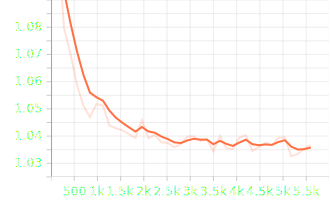

In [54]:
from IPython.display import SVG

SVG("../reports/figures/val_loss.svg")

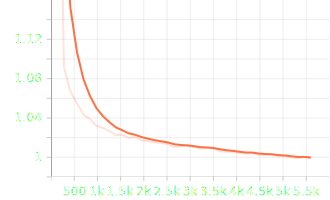

In [55]:
SVG("../reports/figures/train_loss_epoch.svg")